# Newton's method using variational equations

In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
def simple(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1, inc=0.1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    #sim.integrate(100.)
    return np.array((sim.particles[2].x,sim.particles[2].y))
fp_true = simple((1.7,0.1))

In [41]:
def evaluate(x):
    a, e = x
    if (e<0):
        e=0.
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1, inc=0.1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)

    var_da    = sim.add_variational()
    var_dda   = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_da)
    var_de    = sim.add_variational()
    var_dde   = sim.add_variational(order=2,index_1st_order_a=var_de,index_1st_order_b=var_de)
    var_da_de = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_de)
    sim._particles[var_da+2]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a")
    sim._particles[var_de+2]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e")
    sim._particles[var_dda+2]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation_order=2)
    sim._particles[var_dde+2]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e",variation_order=2)
    sim._particles[var_da_de+2] = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation2="e",variation_order=2)

    #sim.integrate(100.)
    
    fp = np.array((sim.particles[2].x,sim.particles[2].y))
    fp_da = np.array((sim.particles[var_da+2].x,sim.particles[var_da+2].y))
    fp_dda = np.array((sim.particles[var_dda+2].x,sim.particles[var_dda+2].y))
    fp_de = np.array((sim.particles[var_de+2].x,sim.particles[var_de+2].y))
    fp_dde = np.array((sim.particles[var_dde+2].x,sim.particles[var_dde+2].y))
    fp_da_de = np.array((sim.particles[var_da_de+2].x,sim.particles[var_da_de+2].y))    
    
    L = np.sqrt(np.dot(fp - fp_true,fp - fp_true))
    
    dL_da = np.dot(fp_da, (fp-fp_true)/L)
    dL_de = np.dot(fp_de, (fp-fp_true)/L)
    
    dL_dda = np.dot(fp_dda, (fp-fp_true)/L) + np.dot(fp_da,fp_da)/L - dL_da*dL_da/L
    dL_dde = np.dot(fp_dde, (fp-fp_true)/L) + np.dot(fp_de,fp_de)/L - dL_de*dL_de/L
    dL_da_de = np.dot(fp_da_de, (fp-fp_true)/L) + np.dot(fp_da,fp_de)/L - dL_da*dL_de/L
                     
    return L, np.array((dL_da,dL_de)), np.array(((dL_dda,dL_da_de),(dL_da_de,dL_dde)))

In [44]:
x = np.array((3.698, 0.105))
N_it = 10
chain = np.zeros((N_it,2))
for i in range(N_it):    
    f, df, ddf = evaluate(x)
    Delta_x = -np.dot(np.linalg.inv(ddf),df)
    #Delta_x = - np.array((1./ddf[0][0]*df[0],0))
    #Delta_x = - np.array((0.,1./ddf[1][1]*df[1]))
    
    chain[i] = x
    print ddf
    print f, df[1], ddf[1][1], x
    
    x = x + 0.1*Delta_x
    


[[ 0. -1.]
 [-1.  0.]]
1.77971 -3.698 0.0 [ 3.698  0.105]
[[ 0. -1.]
 [-1.  0.]]
1.1508651 -3.3282 0.0 [ 3.3282  0.1945]
[[ 0. -1.]
 [-1.  0.]]
0.641500731 -2.99538 0.0 [ 2.99538  0.27505]
[[ 0. -1.]
 [-1.  0.]]
0.22891559211 -2.695842 0.0 [ 2.695842  0.347545]
[[ 0.  1.]
 [ 1.  0.]]
0.105278370391 2.4262578 0.0 [ 2.4262578  0.4127905]
[[ 0.  1.]
 [ 1.  0.]]
0.375975480017 2.18363202 0.0 [ 2.18363202  0.47151145]
[[ 0.  1.]
 [ 1.  0.]]
0.595240138813 1.965268818 0.0 [ 1.96526882  0.5243603 ]
[[ 0.  1.]
 [ 1.  0.]]
0.772844512439 1.7687419362 0.0 [ 1.76874194  0.57192427]
[[ 0.  1.]
 [ 1.  0.]]
0.916704055076 1.59186774258 0.0 [ 1.59186774  0.61473185]
[[ 0.  1.]
 [ 1.  0.]]
1.03323028461 1.43268096832 0.0 [ 1.43268097  0.65325866]


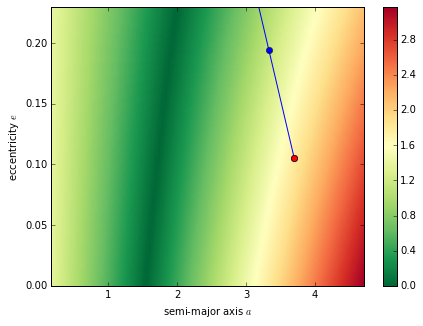

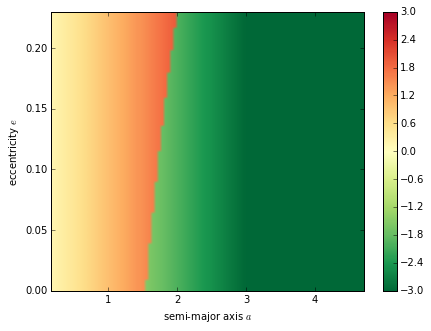

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(grid_a),max(grid_a),min(grid_e),max(grid_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(grid, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent) #interpolation="none",
ax.plot(chain[:,0],chain[:,1])
ax.plot(chain[:,0],chain[:,1],"ro",color="blue")
ax.plot(chain[0,0],chain[0,1],"ro")
cb = plt.colorbar(im, ax=ax)

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(grid_a),max(grid_a),min(grid_e),max(grid_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(grid_grad_a, cmap="RdYlGn_r", vmin=-3, vmax=3,origin="lower", aspect='auto', extent=extent) #interpolation="none",
cb = plt.colorbar(im, ax=ax)

In [28]:
N=100
grid = np.zeros((N,N))
grid_grad_a = np.zeros((N,N))
grid_a = np.linspace(.1695,4.705,N)
grid_e = np.linspace(0.,0.23,N)
for i, a in enumerate(grid_a):
    for j, e in enumerate(grid_e):
        fp, fp_da = simple_grad((a,e))
        L = np.sqrt(np.dot(fp - fp_true,fp - fp_true))
        dL_da = np.dot(fp_da, (fp-fp_true)/L)
        grid[j][i] = L
        grid_grad_a[j][i] = dL_da

In [22]:
def simple_grad(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1, inc=0.1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    var_da    = sim.add_variational()
    vp_da    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e")
    sim._particles[var_da+2]    = vp_da

    #sim.integrate(100.)
    return np.array((sim.particles[2].x,sim.particles[2].y)),np.array((sim.particles[var_da+2].x,sim.particles[var_da+2].y))
